**D3APL: Aplicações em Ciência de Dados** <br/>
IFSP Campinas

Prof. Dr. Samuel Martins (Samuka) <br/><br/>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

# Multilayer Perceptron (MLP) with Keras

## 1. Set up

#### 1.1 TensorFlow + Keras

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
tf.__version__

'2.8.0'

In [3]:
keras.__version__

'2.8.0'

**GPU available?**

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 1.2 Fixing the seed for reproducibility (optional)
That's a try for reprodubility in Keras. See more on: <br/>
https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ <br/>
https://www.tensorflow.org/api_docs/python/tf/random/set_seed

In [5]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(42)
set_seed(42)

#### 1.3 Other imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt

#### 1.4 Loading Fashion MNIST Dataset via Keras
https://keras.io/api/datasets/fashion_mnist/

In [7]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

The dataset is already split into a training set and a test set.

In [8]:
# download done in folder: "~/.keras/datasets"
import os
os.listdir(os.path.expanduser('~/.keras/datasets'))

['fashion-mnist', 'mnist.npz']

In [10]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}\n')

print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (60000, 28, 28)
y_train.shape: (60000,)

X_test.shape: (10000, 28, 28)
y_test.shape: (10000,)


In [11]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [12]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [13]:
print(f'Number of Classes: {np.unique(y_train).shape[0]}')
print(f'Classes: {np.unique(y_train)}')

Number of Classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]


In [14]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

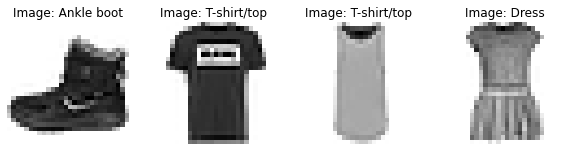

In [15]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, X_train, y_train):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f'Image: {class_names[label]}')

In [17]:
# 8-bit gray scale
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

print(f'Min. value of X_test: {X_test.min()}')
print(f'Max. value of X_test: {X_test.max()}')

Min. value of X_train: 0
Max. value of X_train: 255

Min. value of X_test: 0
Max. value of X_test: 255


#### 1.5 (Simple) Feature scaling
Since we are going to train the neural network using _Gradient Descent_, we must scale the **input features**. For simplicity, we’ll scale the pixel intensities down to the _0–1_ range by dividing them by **255.0** (8-bit gray image):

In [18]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [19]:
# rescaled 8-bit gray scale
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

print(f'Min. value of X_test: {X_test.min()}')
print(f'Max. value of X_test: {X_test.max()}')

Min. value of X_train: 0.0
Max. value of X_train: 1.0

Min. value of X_test: 0.0
Max. value of X_test: 1.0


#### 1.6 Flattening the images as feature vectors

In [25]:
# X_train.shape ==> (n_train_imgs, img_width, img_height)
n_train_imgs, img_width, img_height = X_train.shape

n_pixels = img_width * img_height
n_pixels

784

In [26]:
# X_test.shape ==> (n_test_imgs, img_width, img_height)
n_test_imgs = X_test.shape[0]
n_test_imgs

10000

In [32]:
X_train = np.reshape(X_train, (n_train_imgs, n_pixels))
X_test = np.reshape(X_test, (n_test_imgs, n_pixels))

In [33]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')

X_train.shape: (60000, 784)
X_test.shape: (10000, 784)


## 2. Building and Training a MLP via Keras

### 2.1 Defining the Network Architecture
Proposed architecture for Multiclass Classification:
- Input Layer: 784 neurons (number of pixels)
- Hidden Layer 1: 256 neurons, ReLu
- Hidden Layer 2: 128 neurons, ReLu
- Output Layer: 10 neurons, Softmax

In short: [784], [256 ReLU, 128 ReLU], [10 Softmax] ==> pyramid

#### **Defining the Network's Architecture**

In [37]:
# Sequential: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
# InputLayer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer
# Dense: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

### Default weight and bias initialization:
# kernel_initializer='glorot_uniform',
# bias_initializer='zeros',


from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense

model = Sequential()
model.add(InputLayer(input_shape=(n_pixels,)))  # InputLayer will be ignored in the .summary() method.
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

##### **Summarizing Architecture**

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


##### **Creating a Model (archicture) from a list of Layers**

In [39]:
model = Sequential(
    layers=[
        InputLayer(input_shape=(n_pixels,)),
        Dense(300, activation='relu'),
        Dense(100, activation='relu'),
        Dense(10, activation='softmax')
    ]
)

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


##### **Named Layers (without spaces)**

In [41]:
# Optionally, we can define names for each layer and for the model
model = Sequential(name='MyMLP')
model.add(InputLayer(input_shape=(n_pixels,), name='Input'))  # InputLayer will be ignored in the .summary() method.
model.add(Dense(300, activation='relu', name='Hidden_1'))
model.add(Dense(100, activation='relu', name='Hidden_2'))
model.add(Dense(10, activation='softmax', name='Output'))

In [43]:
model.summary()

Model: "MyMLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_1 (Dense)            (None, 300)               235500    
                                                                 
 Hidden_2 (Dense)            (None, 100)               30100     
                                                                 
 Output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### 2.2 Info about the Architecture

#### **List of layers (except the input layer)**

#### **Getting a specific layer**

According to our convention:
- Layer 1: Input Layer
- Layer 2: Hidden Layer 1
- Layer 3: Hidden Layer 2
- Layer 4: Output Layer

#### **Accessing the weights and biases of a layer**

PS: While the model is not trained, the layer's weights and biases come from the initialization

In [ ]:
print('Hidden 1')
print(f'weights.shape = {weights.shape}')
print(f'biases.shape = {biases.shape}')

**PS:** Note that the **Weight Matrix's shape** has a different _order/convention_ from what we have seen so far.

In [ ]:
print(weights)

In [ ]:
print(biases)

#### **There are other getters (`get_`)**

**PS:** There are the corresponding setter methods (`set_`).

### 2.2 Compiling: Defining the Loss Function, Optimizer, and Metrics

In [ ]:
# Model compilation: https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile


#### **Loss:**

We use the `"sparse_categorical_crossentropy"` loss because we have **sparse labels** (i.e., for each instance, there is just a target class index, from 0 to 9 in this case), and the classes are **exclusive**.

If instead we had _one target probability per class_ for each instance (such as one-hot vectors, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the `"categorical_crossentropy"` loss instead.

If we were doing **binary classification** (with one or more binary labels), then we would use the `"sigmoid"` _activation function_ in the **output layer**, and we would use the `"binary_crossentropy"` loss.

#### **Optimizer:**

`"sgd"` means that we will train the model using simple **Stochastic Gradient Descent** with its default values (see https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD).<br/>
To change some default value, for example the _learning rate_, use `optimizer=keras.optimizers.SGD(lr=???)`.

There are other otimizers available in Keras: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

#### **Metrics:**
List of _metrics_ to be evaluated by the model during **training** and **testing**. <br/>
Each of this can be a _string_ (name of a built-in function), _function_ or a `tf.keras.metrics.Metric` instance: https://www.tensorflow.org/api_docs/python/tf/keras/metrics

**PS:** By default, _F1 score_ **is not** part of keras metrics. To use it, we need to create our own function and pass it to `metrics`: https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=By%20default%2C%20f1%20score%20is,like%20accuracy%2C%20categorical%20accuracy%20etc. <br/>
Other option is to use [**TensorFlow Addons**](https://www.tensorflow.org/addons) that provides several additional functionalities to TensorFlow, such as [**F1 Score**](https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score): https://stackoverflow.com/a/71705026/7069696



### 2.4 Training

In case of GPU drivers, we can monitor its use by [_gpustat_](https://github.com/wookayin/gpustat).

On terminal, use: `gpustat -cpi`


In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit



<br/>

We are using a _validation set_ during training by the argument `validation_split`: https://www.tensorflow.org/api_docs/python/tf/distribute/experimental/ParameterServerStrategy
 <br/>
For example, `validation_split=0.2` tells Keras to use **the last** 20% of the data (before shuffling) for **validation**. <br/>

Additionally, the argument `validation_batch_size` tells the number of samples per **validation batch**. If _unspecified_, will default to `batch_size`.

#### **Checking the training history object**

#### **Visualizing the training history**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
history_df

In [ ]:
history_df.plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('Epochs')
plt.ylabel('Score')

The _training set_ performance ends up beating the _validation performance_, as is generally the case when you train for long enough. <br/>
You can tell that the model _has not quite converged yet_, as the _validation loss_ is still (or could be) going down, so you should probably
**continue training**.

It’s as simple as calling the `fit()` method again, since Keras **_just_ continues training where it left off**.

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Note that our _training loss_ is lower than that from the last epoch in the previous training. This confirms that our `fit()` method **continues training** where it left off.

#### **More about training in Keras**
Extracted from "A. Géron, Hands-on Machine Learning (Chapter 10)".

If the training set was _very skewed_, with some classes being _overrepresented_ and others _underrepresented_, it would be useful to set the `class_weight` argument when calling the `fit()` method, which would give a **larger weight** to _underrepresented classes_ and a **lower weight** to _overrepresented classes_. These weights would be used by Keras when _computing the loss_.

If you need _per-instance weights_, set the `sample_weight` argument (if both `class_weight` and `sample_weight` are provided, Keras **multiplies them**).

_Per-instance weights_ could be useful if some instances were labeled by _experts_ while others were labeled using a _crowdsourcing platform_: you might want to give more weight to the former.

#### **Saving a Model**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#save

See also:
- `save_spec`: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#save_spec
- `save_weights`: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#save_weights

#### **Loading a Model**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#example_8

See also:
- `load_weights`: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#load_weights

### 2.5 Evaluating and Predicting New Samples

#### **Evaluation**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#evaluate

#### **Prediction**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict

#### **Class Prediction**
https://stackoverflow.com/a/69503180/7069696

# Exercise

Repeat all steps shown in this notebook for the MNIST dataset available in Keras: <br/>
https://keras.io/api/datasets/mnist/